<a href="https://colab.research.google.com/github/mitesh98/Amazon-Fine-Food-Review/blob/master/XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Amazon Fine Food Reviews Analysis
Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.

Number of reviews: 568,454

Number of users: 256,059

Number of products: 74,258

Timespan: Oct 1999 - Oct 2012

Number of Attributes/Columns in data: 10

Attribute Information:

Id

ProductId - unique identifier for the product

UserId - unqiue identifier for the user

ProfileName

HelpfulnessNumerator - number of users who found the review helpful

HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not

Score - rating between 1 and 5

Time - timestamp for the review

Summary - brief summary of the review Text - text of the review

Objective: Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).



In [0]:
%matplotlib inline 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

import re
import nltk

from sklearn import metrics
from sklearn.metrics import confusion_matrix

import tqdm

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

from mpl_toolkits.mplot3d import Axes3D

In [0]:
import sqlite3

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!cp "/content/drive/My Drive/database.sqlite" "database.sqlite"

# Reading Data

In [0]:
con=sqlite3.connect("database.sqlite")

In [6]:
filtered_data=pd.read_sql_query("SELECT * FROM `Reviews` WHERE `Score` !=3",con)
filtered_data.shape
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [0]:
# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

In [8]:
actual_score=filtered_data['Score']
posnegative=actual_score.map(partition)
filtered_data['Score']=posnegative
filtered_data.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...


# 2. Exploratory Data Analysis
# 2.1 Data Cleaning: Deduplication
It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.

In [9]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId',axis=0,ascending=True)
sorted_data.shape

(525814, 10)

In [10]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={'UserId','ProfileName','Time','Text'},keep='first',inplace=False)
final.shape

(364173, 10)

**Observation:-** bold text It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
final.shape

(364171, 10)

In [12]:
final['Score'].value_counts()

1    307061
0     57110
Name: Score, dtype: int64

# 3. Preprocessing
In the Preprocessing phase we do the following in the order below:-

1.Begin by removing the linksand html tags

2.Expand English language contractions and Remove any punctuations or limited set of special characters like , or . or # etc.

3.Check if the word is made up of english letters and is not alpha-numeric

4.Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)

5.Convert the word to lowercase

6.Remove Stopwords

7.Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)



In [13]:
#print(link)
for i in range(0,1000):
  links=re.findall(r'http\S+',final['Text'].values[i])
  for link in links:
    print(link)

http://www.amazon.com/gp/product/B0002DGRSY">Pro-Treat
http://www.amazon.com/gp/product/B0019O5Z0Q">Charlee
http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br
http://www.amazon.com/gp/product/B0088EDMMS">Hocus
http://www.amazon.com/gp/product/B001AGXEAG">Beetlejuice
http://www.amazon.com/gp/product/B001AGXEAG">here</a>.
http://www.amazon.com/gp/product/B001AGXEA6">here</a>.
http://www.amazon.com/gp/product/0790700506">Gremlins</a><br
http://www.amazon.com/gp/product/6301871952">Gremlins
http://www.amazon.com/gp/product/6303347657">Mask</a><br
http://www.amazon.com/gp/product/6304826141">Rocketman</a><br
http://www.amazon.com/gp/product/B001B504LI">The
http://www.amazon.com/gp/product/B001AGXEA6">Beetlejuice
http://www.amazon.com/gp/product/B00004RAMX">Victor
http://www.amazon.com/gp/product/B00004RAMY">Victor
http://www.amazon.com/gp/product/B00004RAMY">Victor
http://www.amazon.com/gp/product/B001VJ3FP6">SentryHOME
http://www.amazon.com/gp/product/B0051GCTAW">Fiprogua

In [0]:
for i in range(0,364171):
  final['Text'].values[i] = re.sub(r"http\S+", "", final['Text'].values[i])

In [0]:
#Remove HTML tags
from bs4 import BeautifulSoup
for i in range(1,364171):
  soup = BeautifulSoup(final['Text'].values[i],'lxml')
  text = soup.get_text()
  final['Text'].values[i]=text

In [0]:
#Expanding English language contractions
def decontracted(phrase):
  # specific
  phrase = re.sub(r"won\'t", "will not", phrase)
  phrase = re.sub(r"can\'t", "can not", phrase)

  # general
  phrase = re.sub(r"n\'t", " not", phrase)
  phrase = re.sub(r"\'re", " are", phrase)
  phrase = re.sub(r"\'s", " is", phrase)
  phrase = re.sub(r"\'d", " would", phrase)
  phrase = re.sub(r"\'ll", " will", phrase)
  phrase = re.sub(r"\'t", " not", phrase)
  phrase = re.sub(r"\'ve", " have", phrase)
  phrase = re.sub(r"\'m", " am", phrase)
  return phrase


In [0]:
for i in range(0,364171):
  #print(final['Text'].values[i])
  final['Text'].values[i]=decontracted(final['Text'].values[i])
  #print(final['Text'].values[i])

In [0]:
#remove words with numbers python
for i in range(1,364171):
  #print(final['Text'].values[i])
  final['Text'].values[i] = re.sub("\S*\d\S*", "", final['Text'].values[i]).strip()
  #print(final['Text'].values[i])

In [0]:
#remove spacial character:
for i in range(1,364171):
  final['Text'].values[i]= re.sub('[^A-Za-z0-9]+', ' ', final['Text'].values[i])


In [0]:
#Remove punctution
for i in range(1,364171):
  final['Text'].values[i]= re.sub(r'[!|#|$\%|&|*|?|,|.|\'|/|"|)|(]',r'', final['Text'].values[i])

In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
#tqdm
#Instantly make your loops show a smart progress meter
# just wrap any iterable with tqdm(iterable), and you’re done!
from tqdm import tqdm
preprocessed_reviews = []
for i in tqdm(range(0,364171)):
  sentence=""
  #print(final['Text'].values[i])
  for word in final['Text'].values[i].split():
    #print(word)
    word =word.lower()
    if word not in stopwords:
      sentence+=" "+word
  #print(sentence)
  preprocessed_reviews.append(sentence.strip())

100%|██████████| 364171/364171 [00:15<00:00, 23392.21it/s]


In [23]:
final['Cleaned_text']=preprocessed_reviews
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Cleaned_text
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witty little book makes son laugh loud. recite...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version",I grew up reading these Sendak books and watch...,grew reading sendak books watching really rosi...
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn months year learn poems...
138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,1,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud it h...,great little book read aloud nice rhythm well ...
138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,1,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,book poetry months year goes month cute little...


In [0]:
#Randomly sample Data 100k points
random_sample_data = final.sample(n=100000) 

In [0]:
final_sorted_time=random_sample_data.sort_values('Time',ascending=True,axis=0)

**Time Based Splitting**

In [0]:
#y_Train=final_sorted_time['Score'][0:70000]
y_train=final_sorted_time['Score'][0:49000]
y_cv=final_sorted_time['Score'][49000:70000]
y_test=final_sorted_time['Score'][70000:100000]

In [27]:
y_train.value_counts()

1    42181
0     6819
Name: Score, dtype: int64

In [0]:
Train_data=final_sorted_time['Cleaned_text'][0:70000]
train_data=final_sorted_time['Cleaned_text'][0:49000]
cv_data=final_sorted_time['Cleaned_text'][49000:70000]
test_data=final_sorted_time['Cleaned_text'][70000:100000]

# 4. Featurization
# 4.1Bag of Words

In [0]:
count_vector=CountVectorizer()
count_vector.fit(train_data)
train_bows=count_vector.transform(train_data)
cv_bows=count_vector.transform(cv_data)
test_bows=count_vector.transform(test_data)

# 4.2 TFIDF

In [0]:
tfidf_vector=TfidfVectorizer()
tfidf_vector.fit(train_data)
train_tfidf=tfidf_vector.transform(train_data)
cv_tfidf=tfidf_vector.transform(cv_data)
test_tfidf=tfidf_vector.transform(test_data)

# 4.3 Word2Vec

In [0]:
import gensim
from gensim.models import Word2Vec

In [0]:
#Train own W2V with train data
i=0
list_of_sentence=[]
for sent in train_data.values:
  list_of_sentence.append(sent.split())

In [0]:
w2v_model=gensim.models.Word2Vec(list_of_sentence,min_count=5,size=50,workers=4)
w2v_words = list(w2v_model.wv.vocab)

In [35]:
# Average W2V with training Data
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sentence: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            #print("vec= ",vec)
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
#print(sent_vectors)
print(len(sent_vectors[0]))

49000
50


In [0]:
#Train own W2V with cv data
i=0
list_of_sentence_cv=[]
for sent in cv_data.values:
  list_of_sentence_cv.append(sent.split())

In [0]:
w2v_model_cv=gensim.models.Word2Vec(list_of_sentence_cv,min_count=5,size=50,workers=4)
w2v_words_cv = list(w2v_model_cv.wv.vocab)

In [38]:
# Average W2V with cv Data
sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sentence_cv: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_cv:
            vec = w2v_model_cv.wv[word]
            #print("vec= ",vec)
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
print(len(sent_vectors_cv))
#print(sent_vectors)
print(len(sent_vectors_cv[0]))

21000
50


In [0]:
#Train own W2V with Test data
i=0
list_of_sentence_test=[]
for sent in test_data.values:
  list_of_sentence_test.append(sent.split())

In [0]:
w2v_model_test=gensim.models.Word2Vec(list_of_sentence_test,min_count=5,size=50,workers=4)
w2v_words_test = list(w2v_model_test.wv.vocab)

In [41]:
# Average W2V with test Data
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sentence_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_test:
            vec = w2v_model_test.wv[word]
            #print("vec= ",vec)
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
#print(sent_vectors)
print(len(sent_vectors_test[0]))

30000
50


# 4.4 TFIDF-W2Vec

In [0]:
#TF-IDF Avg W2V for train Data
model_train = TfidfVectorizer()
model_train.fit(train_data)
tf_idf_matrix_train = model_train.transform(train_data)
dictionary = dict(zip(model_train.get_feature_names(), list(model_train.idf_)))

In [0]:
tfidf_feat_train = model_train.get_feature_names() 

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sentence: 
  sent_vec = np.zeros(50) 
  weight_sum =0; 
  for word in sent: 
    try:
      vec = w2v_model.wv[word]
      tf_idf = dictionary[word]*(sent.count(word)/len(sent))
      sent_vec += (vec * tf_idf)
      weight_sum += tf_idf
    except:
      pass
          
  if weight_sum != 0:
    sent_vec /= weight_sum
  tfidf_sent_vectors_train.append(sent_vec)
  row += 1

In [0]:
#TF-IDF Avg W2V for cv Data
model_cv = TfidfVectorizer()
tf_idf_matrix_cv = model_cv.fit_transform(cv_data)
dictionary = dict(zip(model_cv.get_feature_names(), list(model_cv.idf_)))

In [0]:
tfidf_feat_cv = model_cv.get_feature_names() 

tfidf_sent_vectors_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sentence_cv: 
  sent_vec = np.zeros(50) 
  weight_sum =0; 
  for word in sent:
    try:
      vec = w2v_model_cv.wv[word]
      tf_idf = dictionary[word]*(sent.count(word)/len(sent))
      sent_vec += (vec * tf_idf)
      weight_sum += tf_idf
    except:
      pass
          
  if weight_sum != 0:
    sent_vec /= weight_sum
  tfidf_sent_vectors_cv.append(sent_vec)
  row += 1

In [0]:
#TF-IDF Avg W2V for test Data
model_test = TfidfVectorizer()
tf_idf_matrix_test = model_test.fit_transform(test_data)
dictionary = dict(zip(model_test.get_feature_names(), list(model_test.idf_)))

In [0]:
tfidf_feat_test = model_test.get_feature_names() 

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sentence_test: 
  sent_vec = np.zeros(50) 
  weight_sum =0; 
  for word in sent:
    try:
      vec = w2v_model_test.wv[word]
      tf_idf = dictionary[word]*(sent.count(word)/len(sent))
      sent_vec += (vec * tf_idf)
      weight_sum += tf_idf
    except:
      pass
          
  if weight_sum != 0:
    sent_vec /= weight_sum
  tfidf_sent_vectors_test.append(sent_vec)
  row += 1

# 5.XGBoost

# 5.2.1 XGBoost on BoWs

In [0]:
import xgboost as xgb

In [0]:
#n_estimators
N=[5,10,50,100,500]
Depth=[2,3,5,8,10]

In [50]:
AUC_training=[]
AUC_cv=[]
for d in Depth:
  print("========For d= ",d,"=============")
  for n in N:
    print(" ----n = ",n,"-----")
    clf=xgb.XGBClassifier(n_estimators=n,max_depth=d)
    clf.fit(train_bows,y_train)
   
    
    #Training Data
    y_predict_training=clf.predict_proba(train_bows)[:,1]
    auc=roc_auc_score(y_train,y_predict_training)
    AUC_training.append(auc)
    print("Train AUC = ",auc)
    #CV Curve
    y_predict_cv=clf.predict_proba(cv_bows)[:,1]
    auc=roc_auc_score(y_cv,y_predict_cv)
    AUC_cv.append(auc)
    print("Test AUC = ",auc)


========For d=  2 =============
 ----n =  5 -----
Train AUC =  0.6959881242658615
Test AUC =  0.706559639548298
 ----n =  10 -----
Train AUC =  0.7304721655349629
Test AUC =  0.738980895851578
 ----n =  50 -----
Train AUC =  0.8252113352286633
Test AUC =  0.8298604939472896
 ----n =  100 -----
Train AUC =  0.864045888472189
Test AUC =  0.8657160842201872
 ----n =  500 -----
Train AUC =  0.9284056263248016
Test AUC =  0.9208504026931368
========For d=  3 =============
 ----n =  5 -----
Train AUC =  0.7161882016987671
Test AUC =  0.7239163404157513
 ----n =  10 -----
Train AUC =  0.7498993063152424
Test AUC =  0.7562902257668348
 ----n =  50 -----
Train AUC =  0.849866740772407
Test AUC =  0.8497620040115149
 ----n =  100 -----
Train AUC =  0.887617992293277
Test AUC =  0.8825309142513688
 ----n =  500 -----
Train AUC =  0.9486125006314052
Test AUC =  0.930373766022734
========For d=  5 =============
 ----n =  5 -----
Train AUC =  0.7470487339911851
Test AUC =  0.7552332809169542
 ----n 

**Note :**  *Test AUC is CV AUC (type error)

In [0]:
#Heatmap Representation
AUC_cv_matrices=[AUC_cv[0:5],AUC_cv[5:10],AUC_cv[10:15],AUC_cv[15:20],AUC_cv[20:25]]
AUC_training_matrices=[AUC_training[0:5],AUC_training[5:10],AUC_training[10:15],AUC_training[15:20],AUC_training[20:25]]

In [0]:
df_cv = pd.DataFrame(AUC_cv_matrices, index = [i for i in N],
                  columns = [i for i in Depth])
df_training = pd.DataFrame(AUC_training_matrices, index = [i for i in N],
                  columns = [i for i in Depth])

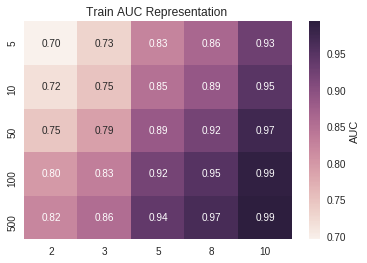

In [53]:
ax = sns.heatmap(df_training,annot=True, fmt=".2f")
ax.set_title("Train AUC Representation ")
ax.collections[0].colorbar.set_label("AUC")

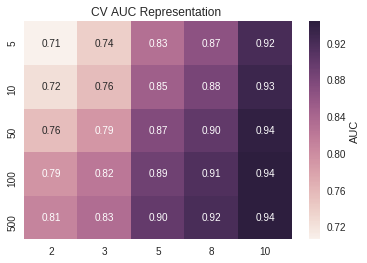

In [54]:
ax = sns.heatmap(df_cv,annot=True, fmt=".2f")
ax.set_title("CV AUC Representation ")
ax.collections[0].colorbar.set_label("AUC")

**Observation:** Optimal value of n_estimators=50 and max_depth=10 having AUC = 0.94

Train AUC =  0.9401688365677257
Test AUC =  0.8948758135964694


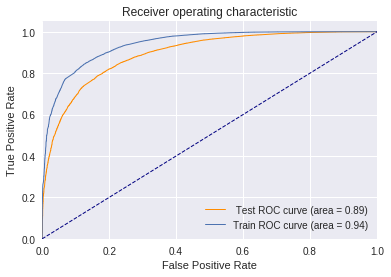

In [55]:
clf=xgb.XGBClassifier(n_estimators=50,max_depth=10 )
clf.fit(train_bows,y_train)

#Train Curve
y_pred_train=clf.predict_proba(train_bows)[:,1]
fpr_train, tpr_train, thresholds_train = roc_curve(y_train,y_pred_train)
roc_auc_train = metrics.auc(fpr_train, tpr_train)

#Test Curve
y_pred=clf.predict_proba(test_bows)[:,1]
fpr, tpr, thresholds = roc_curve(y_test,y_pred)
roc_auc = metrics.auc(fpr, tpr)

#Drawing ROC curve
print('Train AUC = ',metrics.auc(fpr_train, tpr_train))
print('Test AUC = ',metrics.auc(fpr, tpr))
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label=' Test ROC curve (area = %0.2f)' % roc_auc)
plt.plot(fpr_train, tpr_train, lw=1, label='Train ROC curve (area = %0.2f)' % roc_auc_train)

plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()


In [56]:
#Confusion_Matrices
y_pred_train=clf.predict(train_bows)
print("Confusion_Matrices Report for Train Data")
print(metrics.classification_report(y_train,y_pred_train))

y_pred=clf.predict(test_bows)
print("Confusion_Matrices Report for Test Data")
print(metrics.classification_report(y_test,y_pred))

Confusion_Matrices Report for Train Data
              precision    recall  f1-score   support

           0       0.97      0.36      0.53      6819
           1       0.91      1.00      0.95     42181

   micro avg       0.91      0.91      0.91     49000
   macro avg       0.94      0.68      0.74     49000
weighted avg       0.91      0.91      0.89     49000

Confusion_Matrices Report for Test Data
              precision    recall  f1-score   support

           0       0.88      0.27      0.41      5268
           1       0.86      0.99      0.92     24732

   micro avg       0.87      0.87      0.87     30000
   macro avg       0.87      0.63      0.67     30000
weighted avg       0.87      0.87      0.83     30000



In [0]:
cnf_matrix = confusion_matrix(y_test,y_pred)
cnf_matrix_train = confusion_matrix(y_train,y_pred_train)
df_cm = pd.DataFrame(cnf_matrix, index = [i for i in [0,1]],
                  columns = [i for i in [0,1]])
df_cm_train = pd.DataFrame(cnf_matrix_train, index = [i for i in [0,1]],
                  columns = [i for i in [0,1]])

Text(0.5, 1.0, 'Confusion Matrices for test Data')

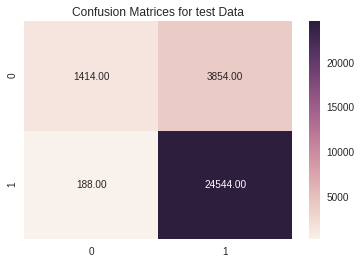

In [58]:
ax = sns.heatmap(df_cm,annot=True, fmt=".2f")
ax.set_title("Confusion Matrices for test Data")

Confusion Matrices for Train Data


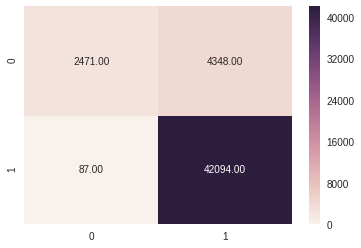

In [59]:
print("Confusion Matrices for Train Data")
ax_train = sns.heatmap(df_cm_train,annot=True, fmt=".2f")

**top 20 important features**

In [60]:
feature_names=count_vector.get_feature_names()
a=clf.feature_importances_
top =zip( feature_names,a)
top=list(top)
top.sort(reverse=True,key=lambda x: x[1])
top_20_features_names=top[0:20]
#top_20_features_vlues=top[1][0:20]
for i in range(1,50):
  print(top[i][0],end="\t")

like	good	would	one	product	taste	great	amazon	no	best	love	unfortunately	flavor	thought	even	tried	disappointed	terrible	also	find	get	delicious	little	make	use	day	however	disappointing	bad	bought	disappointment	much	food	horrible	really	try	money	price	well	buy	tasty	could	loves	worst	better	first	perfect	awful	reviews	

In [61]:
top_20_features_names

[('not', 0.03986761),
 ('like', 0.028734768),
 ('good', 0.023017902),
 ('would', 0.020761246),
 ('one', 0.018504588),
 ('product', 0.01700015),
 ('taste', 0.016699262),
 ('great', 0.014743493),
 ('amazon', 0.013840831),
 ('no', 0.011584173),
 ('best', 0.011132842),
 ('love', 0.010681511),
 ('unfortunately', 0.009026629),
 ('flavor', 0.008575297),
 ('thought', 0.007823078),
 ('even', 0.0076726344),
 ('tried', 0.0076726344),
 ('disappointed', 0.0075221905),
 ('terrible', 0.0073717465),
 ('also', 0.007221303)]

In [0]:
feature_dict={}
i=0
for f,v in top_20_features_names:
  feature_dict[f]=v
  

In [63]:
for f ,v in feature_dict.items():
  print(f)
  print(v)

not
0.03986761
like
0.028734768
good
0.023017902
would
0.020761246
one
0.018504588
product
0.01700015
taste
0.016699262
great
0.014743493
amazon
0.013840831
no
0.011584173
best
0.011132842
love
0.010681511
unfortunately
0.009026629
flavor
0.008575297
thought
0.007823078
even
0.0076726344
tried
0.0076726344
disappointed
0.0075221905
terrible
0.0073717465
also
0.007221303


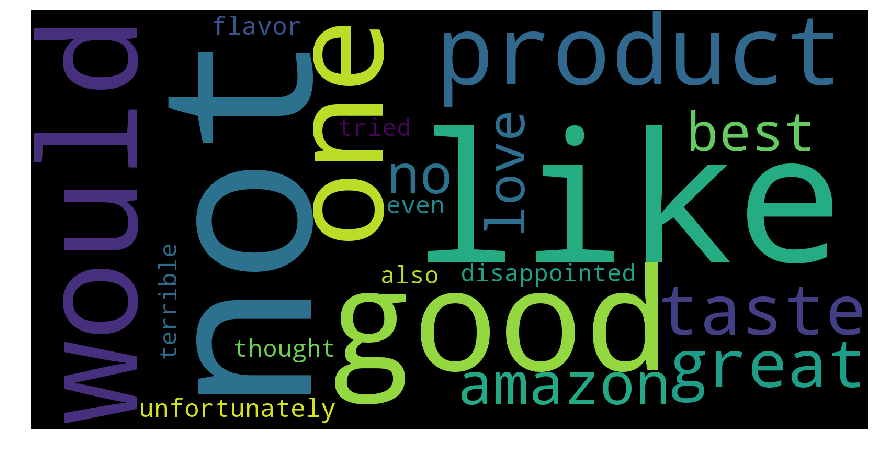

In [64]:
from wordcloud import WordCloud
wordcloud=WordCloud(background_color='black',width=1600,height=800).fit_words(feature_dict)
fig=plt.figure(figsize=(15,15))
plt.imshow(wordcloud)
plt.axis('off')
fig.savefig("feature3.png")
plt.show()

In [0]:
from google.colab import files
files.download('feature3.png')

# 5.2.2 XGBoost on TFIDF

In [0]:
y_train=final_sorted_time['Score'][0:49000]
y_cv=final_sorted_time['Score'][49000:70000]
y_test=final_sorted_time['Score'][70000:100000]

In [67]:
#n_estimators
N=[5,10,50,100,500]
Depth=[2,3,5,8,10]
AUC_training=[]
AUC_cv=[]
for d in Depth:
  print("========For d= ",d,"=============")
  for n in N:
    print(" ----n = ",n,"-----")
    clf=xgb.XGBClassifier(n_estimators=n,max_depth=d )
    clf.fit(train_tfidf,y_train)
   
    
    #Training Data
    y_predict_training=clf.predict_proba(train_tfidf)[:,1]
    auc=roc_auc_score(y_train,y_predict_training)
    AUC_training.append(auc)
    print("Train AUC = ",auc)
    
    #CV Curve
    y_predict_cv=clf.predict_proba(cv_tfidf)[:,1]
    auc=roc_auc_score(y_cv,y_predict_cv)
    AUC_cv.append(auc)
    print("Test AUC = ",auc)

========For d=  2 =============
 ----n =  5 -----
Train AUC =  0.6999231682092493
Test AUC =  0.7063997635857128
 ----n =  10 -----
Train AUC =  0.7361562728022293
Test AUC =  0.7421919096179851
 ----n =  50 -----
Train AUC =  0.8310802183756598
Test AUC =  0.8329400543224291
 ----n =  100 -----
Train AUC =  0.8708189452991046
Test AUC =  0.867753155293834
 ----n =  500 -----
Train AUC =  0.9372101470169344
Test AUC =  0.9229683047085446
========For d=  3 =============
 ----n =  5 -----
Train AUC =  0.7245815202238161
Test AUC =  0.7322039425606182
 ----n =  10 -----
Train AUC =  0.7597316881436228
Test AUC =  0.7652321076549937
 ----n =  50 -----
Train AUC =  0.8573939620168932
Test AUC =  0.8530702423526745
 ----n =  100 -----
Train AUC =  0.8947884002669115
Test AUC =  0.883873638485555
 ----n =  500 -----
Train AUC =  0.9569507644794991
Test AUC =  0.9322046152841997
========For d=  5 =============
 ----n =  5 -----
Train AUC =  0.7524661587048315
Test AUC =  0.7560442491944335
 --

TypeError: Read Test AUC as CV AUC-

**Heatmap Representation**

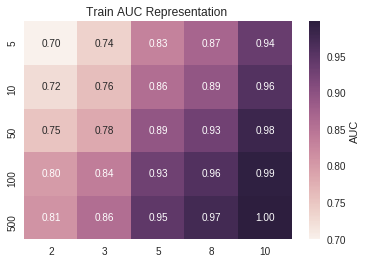

In [68]:
AUC_cv_matrices=[AUC_cv[0:5],AUC_cv[5:10],AUC_cv[10:15],AUC_cv[15:20],AUC_cv[20:25]]
AUC_training_matrices=[AUC_training[0:5],AUC_training[5:10],AUC_training[10:15],AUC_training[15:20],AUC_training[20:25]]
df_cv = pd.DataFrame(AUC_cv_matrices, index = [i for i in N],
                  columns = [i for i in Depth])
df_training = pd.DataFrame(AUC_training_matrices, index = [i for i in N],
                  columns = [i for i in Depth])
ax = sns.heatmap(df_training,annot=True, fmt=".2f")
ax.set_title("Train AUC Representation ")
ax.collections[0].colorbar.set_label("AUC")

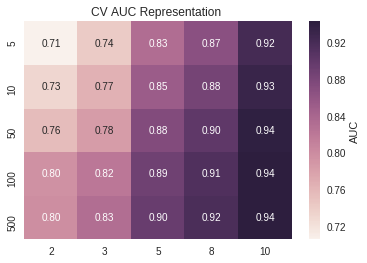

In [69]:
ax = sns.heatmap(df_cv,annot=True, fmt=".2f")
ax.set_title("CV AUC Representation ")
ax.collections[0].colorbar.set_label("AUC")

**observation:** Optimal value of n_estimators=50, max_depth10





Train AUC =  0.9460563841732638
Test AUC =  0.8948935588752122


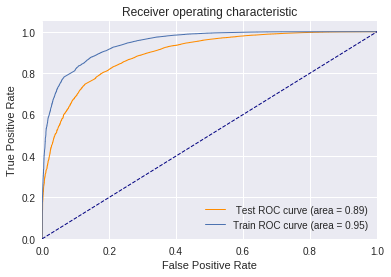

In [70]:
clf=xgb.XGBClassifier(n_estimators=50,max_depth=10 )
clf.fit(train_tfidf,y_train)

#Train Curve
y_pred_train=clf.predict_proba(train_tfidf)[:,1]
fpr_train, tpr_train, thresholds_train = roc_curve(y_train,y_pred_train)
roc_auc_train = metrics.auc(fpr_train, tpr_train)

#Test Curve
y_pred=clf.predict_proba(test_tfidf)[:,1]
fpr, tpr, thresholds = roc_curve(y_test,y_pred)
roc_auc = metrics.auc(fpr, tpr)

#Drawing ROC curve
print('Train AUC = ',metrics.auc(fpr_train, tpr_train))
print('Test AUC = ',metrics.auc(fpr, tpr))
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label=' Test ROC curve (area = %0.2f)' % roc_auc)
plt.plot(fpr_train, tpr_train, lw=1, label='Train ROC curve (area = %0.2f)' % roc_auc_train)

plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [71]:
#Confusion_Matrices
y_pred_train=clf.predict(train_tfidf)
print("Confusion_Matrices Report for Train Data")
print(metrics.classification_report(y_train,y_pred_train))

y_pred=clf.predict(test_tfidf)
print("Confusion_Matrices Report for Test Data")
print(metrics.classification_report(y_test,y_pred))

Confusion_Matrices Report for Train Data
              precision    recall  f1-score   support

           0       0.97      0.37      0.54      6819
           1       0.91      1.00      0.95     42181

   micro avg       0.91      0.91      0.91     49000
   macro avg       0.94      0.68      0.74     49000
weighted avg       0.92      0.91      0.89     49000

Confusion_Matrices Report for Test Data
              precision    recall  f1-score   support

           0       0.89      0.27      0.42      5268
           1       0.87      0.99      0.92     24732

   micro avg       0.87      0.87      0.87     30000
   macro avg       0.88      0.63      0.67     30000
weighted avg       0.87      0.87      0.84     30000



Text(0.5, 1.0, 'Confusion Matrices for test Data')

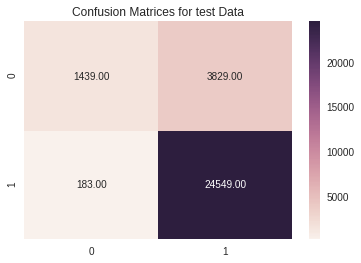

In [72]:
cnf_matrix = confusion_matrix(y_test,y_pred)
cnf_matrix_train = confusion_matrix(y_train,y_pred_train)
df_cm = pd.DataFrame(cnf_matrix, index = [i for i in [0,1]],
                  columns = [i for i in [0,1]])
df_cm_train = pd.DataFrame(cnf_matrix_train, index = [i for i in [0,1]],
                  columns = [i for i in [0,1]])
ax = sns.heatmap(df_cm,annot=True, fmt=".2f")
ax.set_title("Confusion Matrices for test Data")

Confusion Matrices for Train Data


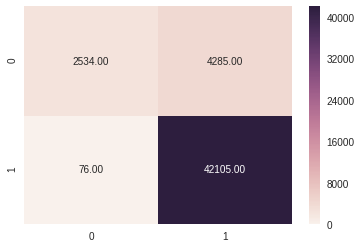

In [73]:
print("Confusion Matrices for Train Data")
ax_train = sns.heatmap(df_cm_train,annot=True, fmt=".2f")

**Top 20 Features**

In [74]:
feature_names=tfidf_vector.get_feature_names()
a=clf.feature_importances_
top =zip( feature_names,a)
top=list(top)
top.sort(reverse=True,key=lambda x: x[1])
top_20_features_names=top[0:20]
#top_20_features_vlues=top[1][0:20]
for i in range(1,50):
  print(top[i][0],end="\t")

like	great	good	would	disappointed	taste	product	best	one	love	amazon	unfortunately	thought	terrible	find	however	delicious	money	no	bad	little	awful	flavor	really	even	loves	reviews	get	try	much	tried	away	date	horrible	opened	perfect	price	well	buy	disappointment	bought	could	disappointing	make	worst	received	use	waste	day	

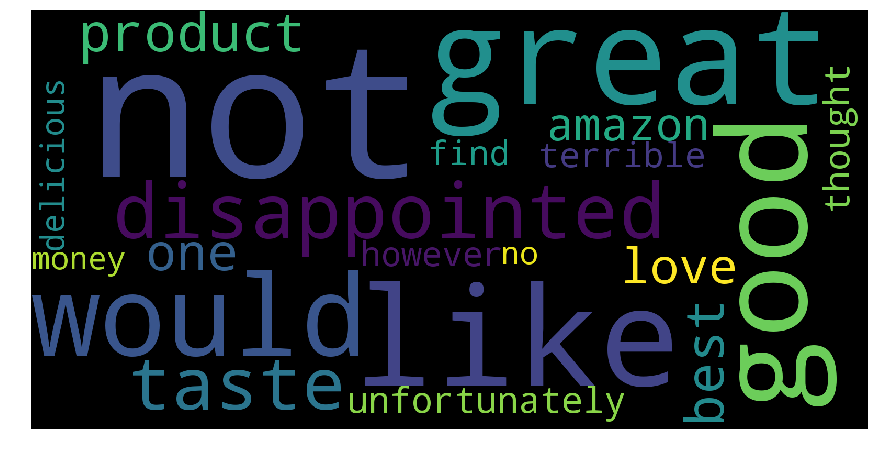

In [75]:
feature_dict={}
for f,v in top_20_features_names:
  feature_dict[f]=v
from wordcloud import WordCloud
wordcloud=WordCloud(background_color='black',width=1600,height=800).fit_words(feature_dict)
fig=plt.figure(figsize=(15,15))
plt.imshow(wordcloud)
plt.axis('off')
fig.savefig("feature4.png")
plt.show() 
from google.colab import files
files.download('feature4.png')

# 5.2.3 XGBoost on Word2Vec

In [0]:
y_train=final_sorted_time['Score'][0:49000]
y_cv=final_sorted_time['Score'][49000:70000]
y_test=final_sorted_time['Score'][70000:100000]

In [0]:
sent_vectors=np.matrix(sent_vectors)
sent_vectors_cv=np.matrix(sent_vectors_cv)
sent_vectors_test=np.matrix(sent_vectors_test)


In [81]:
#n_estimators
N=[5,10,50,100,500]
Depth=[2,3,5,8,10]
AUC_training=[]
AUC_cv=[]
for d in Depth:
  print("========For d= ",d,"=============")
  for n in N:
    print(" ----n = ",n,"-----")
    clf=xgb.XGBClassifier(n_estimators=n,max_depth=d )
    clf.fit(sent_vectors,y_train)
   
    
    #Training Data
    y_predict_training=clf.predict_proba(sent_vectors)[:,1]
    auc=roc_auc_score(y_train,y_predict_training)
    AUC_training.append(auc)
    print("Train AUC = ",auc)
    
    #CV Curve
    y_predict_cv=clf.predict_proba(sent_vectors_cv)[:,1]
    auc=roc_auc_score(y_cv,y_predict_cv)
    AUC_cv.append(auc)
    print("Test AUC = ",auc)

========For d=  2 =============
 ----n =  5 -----
Train AUC =  0.7585805619654478
Test AUC =  0.6576876007834026
 ----n =  10 -----
Train AUC =  0.799748488902873
Test AUC =  0.6761623442174404
 ----n =  50 -----
Train AUC =  0.8660197718656982
Test AUC =  0.7391574617658753
 ----n =  100 -----
Train AUC =  0.8910332666151515
Test AUC =  0.7420721728290949
 ----n =  500 -----
Train AUC =  0.9209617424005103
Test AUC =  0.7649293820433258
========For d=  3 =============
 ----n =  5 -----
Train AUC =  0.7925582013774193
Test AUC =  0.6663199897810085
 ----n =  10 -----
Train AUC =  0.815745068479615
Test AUC =  0.6858906239551261
 ----n =  50 -----
Train AUC =  0.8868388289394777
Test AUC =  0.7445679132474889
 ----n =  100 -----
Train AUC =  0.9076229333944724
Test AUC =  0.749503558027014
 ----n =  500 -----
Train AUC =  0.94257378603516
Test AUC =  0.7668376665941887
========For d=  5 =============
 ----n =  5 -----
Train AUC =  0.841233137986316
Test AUC =  0.6873835577547209
 ----n 

**Heatmap Representation**

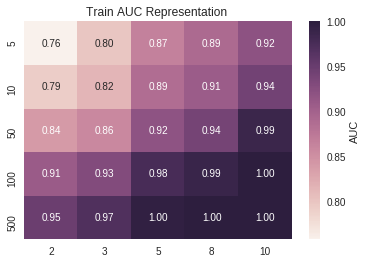

In [82]:
AUC_cv_matrices=[AUC_cv[0:5],AUC_cv[5:10],AUC_cv[10:15],AUC_cv[15:20],AUC_cv[20:25]]
AUC_training_matrices=[AUC_training[0:5],AUC_training[5:10],AUC_training[10:15],AUC_training[15:20],AUC_training[20:25]]
df_cv = pd.DataFrame(AUC_cv_matrices, index = [i for i in N],
                  columns = [i for i in Depth])
df_training = pd.DataFrame(AUC_training_matrices, index = [i for i in N],
                  columns = [i for i in Depth])
ax = sns.heatmap(df_training,annot=True, fmt=".2f")
ax.set_title("Train AUC Representation ")
ax.collections[0].colorbar.set_label("AUC")

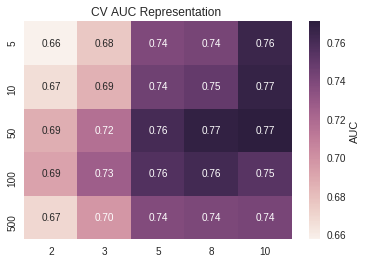

In [83]:
ax = sns.heatmap(df_cv,annot=True, fmt=".2f")
ax.set_title("CV AUC Representation ")
ax.collections[0].colorbar.set_label("AUC")

**observation:** Optimal value of n_estimators=50, max_depth=8

Train AUC =  0.9767893890364634
Test AUC =  0.7329069331663681


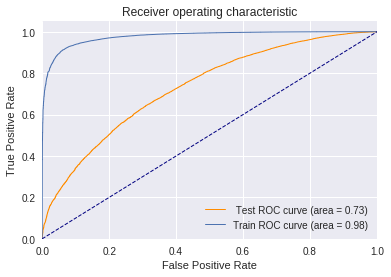

In [84]:
clf=xgb.XGBClassifier(n_estimators=50,max_depth=8 )
clf.fit(sent_vectors,y_train)

#Train Curve
y_pred_train=clf.predict_proba(sent_vectors)[:,1]
fpr_train, tpr_train, thresholds_train = roc_curve(y_train,y_pred_train)
roc_auc_train = metrics.auc(fpr_train, tpr_train)

#Test Curve
y_pred=clf.predict_proba(sent_vectors_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test,y_pred)
roc_auc = metrics.auc(fpr, tpr)

#Drawing ROC curve
print('Train AUC = ',metrics.auc(fpr_train, tpr_train))
print('Test AUC = ',metrics.auc(fpr, tpr))
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label=' Test ROC curve (area = %0.2f)' % roc_auc)
plt.plot(fpr_train, tpr_train, lw=1, label='Train ROC curve (area = %0.2f)' % roc_auc_train)

plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [85]:
#Confusion_Matrices
y_pred_train=clf.predict(sent_vectors)
print("Confusion_Matrices Report for Train Data")
print(metrics.classification_report(y_train,y_pred_train))

y_pred=clf.predict(sent_vectors_test)
print("Confusion_Matrices Report for Test Data")
print(metrics.classification_report(y_test,y_pred))

Confusion_Matrices Report for Train Data
              precision    recall  f1-score   support

           0       0.91      0.61      0.73      6819
           1       0.94      0.99      0.96     42181

   micro avg       0.94      0.94      0.94     49000
   macro avg       0.92      0.80      0.85     49000
weighted avg       0.94      0.94      0.93     49000

Confusion_Matrices Report for Test Data
              precision    recall  f1-score   support

           0       0.72      0.06      0.11      5268
           1       0.83      1.00      0.91     24732

   micro avg       0.83      0.83      0.83     30000
   macro avg       0.78      0.53      0.51     30000
weighted avg       0.81      0.83      0.77     30000



In [0]:
cnf_matrix = confusion_matrix(y_test,y_pred)
cnf_matrix_train = confusion_matrix(y_train,y_pred_train)
df_cm = pd.DataFrame(cnf_matrix, index = [i for i in [0,1]],
                  columns = [i for i in [0,1]])
df_cm_train = pd.DataFrame(cnf_matrix_train, index = [i for i in [0,1]],
                  columns = [i for i in [0,1]])

Text(0.5, 1.0, 'Confusion Matrices for test Data')

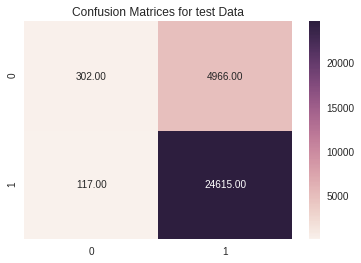

In [87]:
ax = sns.heatmap(df_cm,annot=True, fmt=".2f")
ax.set_title("Confusion Matrices for test Data")

Text(0.5, 1.0, 'Confusion Matrices for Train Data')

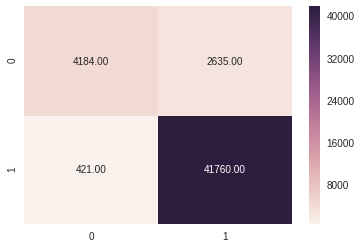

In [88]:
ax_train = sns.heatmap(df_cm_train,annot=True, fmt=".2f")
ax.set_title("Confusion Matrices for Train Data")

# 5.2.4 XGBoost on TFIDF Word2Vec


In [0]:
y_train=final_sorted_time['Score'][0:49000]
y_cv=final_sorted_time['Score'][49000:70000]
y_test=final_sorted_time['Score'][70000:100000]

In [0]:
tfidf_sent_vectors_train=np.matrix(tfidf_sent_vectors_train)
tfidf_sent_vectors_cv=np.matrix(tfidf_sent_vectors_cv)
tfidf_sent_vectors_test=np.matrix(tfidf_sent_vectors_test)


In [91]:
#n_estimators
N=[5,10,50,100,500]
Depth=[2,3,5,8,10]
AUC_training=[]
AUC_cv=[]
for d in Depth:
  print("========For d= ",d,"=============")
  for n in N:
    print(" ----n = ",n,"-----")
    clf=xgb.XGBClassifier(n_estimators=n,max_depth=d, )
    clf.fit(tfidf_sent_vectors_train,y_train)
   
    
    #Training Data
    y_predict_training=clf.predict_proba(tfidf_sent_vectors_train)[:,1]
    auc=roc_auc_score(y_train,y_predict_training)
    AUC_training.append(auc)
    print("Train AUC = ",auc)
    
    #CV Curve
    y_predict_cv=clf.predict_proba(tfidf_sent_vectors_cv)[:,1]
    auc=roc_auc_score(y_cv,y_predict_cv)
    AUC_cv.append(auc)
    print("Test AUC = ",auc)

========For d=  2 =============
 ----n =  5 -----
Train AUC =  0.7286033225225493
Test AUC =  0.6802003514980712
 ----n =  10 -----
Train AUC =  0.7510302939302989
Test AUC =  0.6676706665689617
 ----n =  50 -----
Train AUC =  0.8307928548996901
Test AUC =  0.7178571911948493
 ----n =  100 -----
Train AUC =  0.8598420238282121
Test AUC =  0.7265278133160027
 ----n =  500 -----
Train AUC =  0.901435641920515
Test AUC =  0.7428086770129951
========For d=  3 =============
 ----n =  5 -----
Train AUC =  0.7683835190672073
Test AUC =  0.6577536558322131
 ----n =  10 -----
Train AUC =  0.7840468536630207
Test AUC =  0.6830833084065221
 ----n =  50 -----
Train AUC =  0.8579762854747308
Test AUC =  0.719888856454002
 ----n =  100 -----
Train AUC =  0.8844588888382572
Test AUC =  0.7273133462352106
 ----n =  500 -----
Train AUC =  0.9300011515746676
Test AUC =  0.7445380651428677
========For d=  5 =============
 ----n =  5 -----
Train AUC =  0.8153067361826571
Test AUC =  0.6878644510034994
 --

** Representation in Seaborn Heatmap**

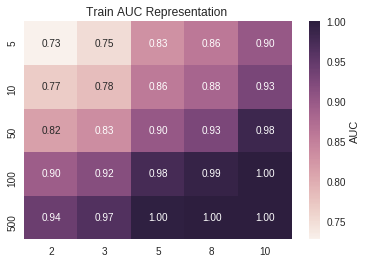

In [92]:
AUC_cv_matrices=[AUC_cv[0:5],AUC_cv[5:10],AUC_cv[10:15],AUC_cv[15:20],AUC_cv[20:25]]
AUC_training_matrices=[AUC_training[0:5],AUC_training[5:10],AUC_training[10:15],AUC_training[15:20],AUC_training[20:25]]
df_cv = pd.DataFrame(AUC_cv_matrices, index = [i for i in N],
                  columns = [i for i in Depth])
df_training = pd.DataFrame(AUC_training_matrices, index = [i for i in N],
                  columns = [i for i in Depth])
ax = sns.heatmap(df_training,annot=True, fmt=".2f")
ax.set_title("Train AUC Representation ")
ax.collections[0].colorbar.set_label("AUC")

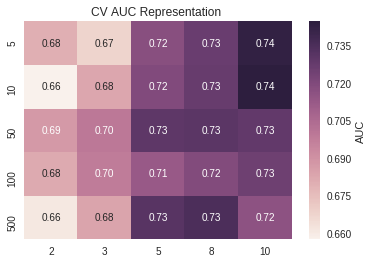

In [93]:
ax = sns.heatmap(df_cv,annot=True, fmt=".2f")
ax.set_title("CV AUC Representation ")
ax.collections[0].colorbar.set_label("AUC")

**observation**: Optimal value of n_estimators=10, max_depth10



Train AUC =  0.9652749374175682
Test AUC =  0.6668339496901086


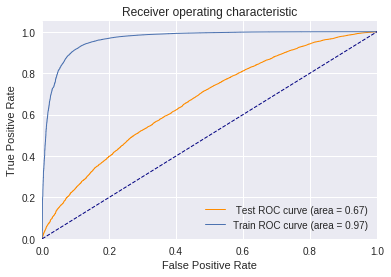

In [95]:
clf=xgb.XGBClassifier(n_estimators=10,max_depth=10 )
clf.fit(tfidf_sent_vectors_train,y_train)

#Train Curve
y_pred_train=clf.predict_proba(tfidf_sent_vectors_train)[:,1]
fpr_train, tpr_train, thresholds_train = roc_curve(y_train,y_pred_train)
roc_auc_train = metrics.auc(fpr_train, tpr_train)

#Test Curve
y_pred=clf.predict_proba(tfidf_sent_vectors_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test,y_pred)
roc_auc = metrics.auc(fpr, tpr)

#Drawing ROC curve
print('Train AUC = ',metrics.auc(fpr_train, tpr_train))
print('Test AUC = ',metrics.auc(fpr, tpr))
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label=' Test ROC curve (area = %0.2f)' % roc_auc)
plt.plot(fpr_train, tpr_train, lw=1, label='Train ROC curve (area = %0.2f)' % roc_auc_train)

plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [96]:
#Confusion_Matrices Report
y_pred_train=clf.predict(tfidf_sent_vectors_train)
print("Confusion_Matrices Report for Train Data")
print(metrics.classification_report(y_train,y_pred_train))

y_pred=clf.predict(tfidf_sent_vectors_test)
print("Confusion_Matrices Report for Test Data")
print(metrics.classification_report(y_test,y_pred))

Confusion_Matrices Report for Train Data
              precision    recall  f1-score   support

           0       0.94      0.51      0.66      6819
           1       0.93      1.00      0.96     42181

   micro avg       0.93      0.93      0.93     49000
   macro avg       0.94      0.75      0.81     49000
weighted avg       0.93      0.93      0.92     49000

Confusion_Matrices Report for Test Data
              precision    recall  f1-score   support

           0       0.57      0.06      0.11      5268
           1       0.83      0.99      0.90     24732

   micro avg       0.83      0.83      0.83     30000
   macro avg       0.70      0.53      0.51     30000
weighted avg       0.79      0.83      0.76     30000



Text(0.5, 1.0, 'Confusion Matrices for test Data')

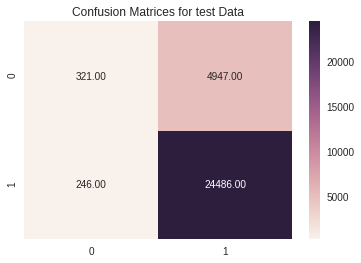

In [97]:
cnf_matrix = confusion_matrix(y_test,y_pred)
cnf_matrix_train = confusion_matrix(y_train,y_pred_train)
df_cm = pd.DataFrame(cnf_matrix, index = [i for i in [0,1]],
                  columns = [i for i in [0,1]])
df_cm_train = pd.DataFrame(cnf_matrix_train, index = [i for i in [0,1]],
                  columns = [i for i in [0,1]])
ax = sns.heatmap(df_cm,annot=True, fmt=".2f")
ax.set_title("Confusion Matrices for test Data")

Text(0.5, 1.0, 'Confusion Matrices for Train Data')

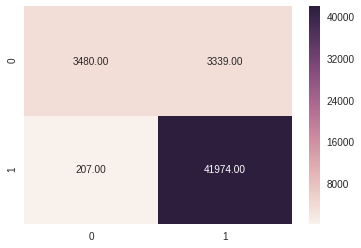

In [98]:
ax_train = sns.heatmap(df_cm_train,annot=True, fmt=".2f")
ax.set_title("Confusion Matrices for Train Data")

# Conclusion table-2:

In [99]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Vectorizer", "N_estimators", "Max_Depth", "AUC"]
x.add_row(["BOWs",50, 10, 0.89])
x.add_row(["TFIDF",50, 10, 0.89])
x.add_row(["W2Vec",50, 8, 0.73])
x.add_row(["TFIDFW2Vec",10, 10, 0.66])
print (x)

+------------+--------------+-----------+------+
| Vectorizer | N_estimators | Max_Depth | AUC  |
+------------+--------------+-----------+------+
|    BOWs    |      50      |     10    | 0.89 |
|   TFIDF    |      50      |     10    | 0.89 |
|   W2Vec    |      50      |     8     | 0.73 |
| TFIDFW2Vec |      10      |     10    | 0.66 |
+------------+--------------+-----------+------+
